<a href="https://colab.research.google.com/github/VictoriaPedrozaAI/NLP-Projects/blob/main/Financial_News_DistilRoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
!pip install -q transformers datasets torch scikit-learn pandas tqdm matplotlib seaborn

In [2]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import warnings
warnings.filterwarnings('ignore')

## Mount Drive - Financial News Dataset



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset from: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news/code

In [4]:
df2 = pd.read_csv('/content/drive/MyDrive/NLP - Project/Task 2/financial.csv',
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")

## Pre-processing

In [5]:
df2.isnull().sum()

,0
sentiment,0
text,0


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   text       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [7]:
df2.shape

(4846, 2)

In [8]:
df2.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


### Lower casing

In [9]:
df2['text'] = df2['text'].apply(lambda x: x.lower())

In [10]:
df2.head()

,sentiment,text
0,neutral,"according to gran , the company has no plans t..."
1,neutral,technopolis plans to develop in stages an area...
2,negative,the international electronic industry company ...
3,positive,with the new production plant the company woul...
4,positive,according to the company 's updated strategy f...


## Model DistilRoBERTa



>  Hugging Face: https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis


In [11]:
# Model
MODEL = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

dtype = torch.float16 if device == 0 else torch.float32
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    dtype=dtype
)

tokenizer = AutoTokenizer.from_pretrained(MODEL)

sentiment_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device,
    return_all_scores=False,
    max_length=128,
    truncation=True,
    padding=True,
    batch_size=16
)

Using device: CPU


config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [12]:
def process_chunk(texts, batch_size=32):
    texts = texts.astype(str).tolist()
    results = sentiment_pipeline(texts, batch_size=batch_size)
    labels = [r['label'].lower() for r in results]
    scores = [r['score'] for r in results]
    return labels, scores

# New columns
if 'distilroberta_sentiment' not in df2.columns:
    df2['distilroberta_sentiment'] = ""
if 'distilroberta_confidence' not in df2.columns:
    df2['distilroberta_confidence'] = 0.0

# Process in chunks
CHUNK_SIZE = 256
BATCH_SIZE = 16
num_chunks = len(df2) // CHUNK_SIZE + (1 if len(df2) % CHUNK_SIZE else 0)

all_labels = []
all_confidences = []

for i in tqdm(range(num_chunks), desc="Inferring Sentiment"):
    start = i * CHUNK_SIZE
    end = min((i + 1) * CHUNK_SIZE, len(df2))
    chunk_texts = df2['text'].iloc[start:end]

    labels, confidences = process_chunk(chunk_texts, batch_size=BATCH_SIZE)
    all_labels.extend(labels)
    all_confidences.extend(confidences)

    # Clear memory
    if device == 0:
        torch.cuda.empty_cache()
    gc.collect()

df2['distilroberta_sentiment'] = all_labels
df2['distilroberta_confidence'] = all_confidences

Inferring Sentiment: 100%|██████████| 19/19 [08:35<00:00, 27.11s/it]


In [13]:
df2.shape

(4846, 4)

In [14]:
df2.head(50)

,sentiment,text,distilroberta_sentiment,distilroberta_confidence
0,neutral,"according to gran , the company has no plans t...",neutral,0.999793
1,neutral,technopolis plans to develop in stages an area...,neutral,0.999894
2,negative,the international electronic industry company ...,negative,0.978173
3,positive,with the new production plant the company woul...,positive,0.999697
4,positive,according to the company 's updated strategy f...,positive,0.999580
5,positive,financing of aspocomp 's growth aspocomp is ag...,positive,0.998474
6,positive,"for the last quarter of 2010 , componenta 's n...",positive,0.999647
7,positive,"in the third quarter of 2010 , net sales incre...",positive,0.999726
8,positive,operating profit rose to eur 13.1 mn from eur ...,positive,0.999739
9,positive,"operating profit totalled eur 21.1 mn , up fro...",positive,0.999746


### Measure sentiment in unseen data

In [15]:
sentences = [
    "Apple-supplier Luxshare shares pop 10% on report of OpenAI hardware deal",
    "South Korea’s President Lee says U.S. investment demands would spark a financial crisis",
    "White House says TikTok’s algorithm and data will be controlled ‘by America’",
    "The new policy is a total disaster, but I'm thrilled about the chaos it brings!"
]

results = sentiment_pipeline(sentences)

for i, sentence in enumerate(sentences):
    label = results[i]['label'].lower()
    score = results[i]['score']
    print(f"\"{sentence}\" → {label} ({score:.3f})")

"Apple-supplier Luxshare shares pop 10% on report of OpenAI hardware deal" → positive (0.999)
"South Korea’s President Lee says U.S. investment demands would spark a financial crisis" → negative (0.997)
"White House says TikTok’s algorithm and data will be controlled ‘by America’" → neutral (1.000)
"The new policy is a total disaster, but I'm thrilled about the chaos it brings!" → positive (0.987)



 Accuracy: 0.8558

 Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.77      0.82       604
     neutral       0.88      0.89      0.89      2879
    positive       0.80      0.81      0.81      1363

    accuracy                           0.86      4846
   macro avg       0.85      0.83      0.84      4846
weighted avg       0.86      0.86      0.86      4846



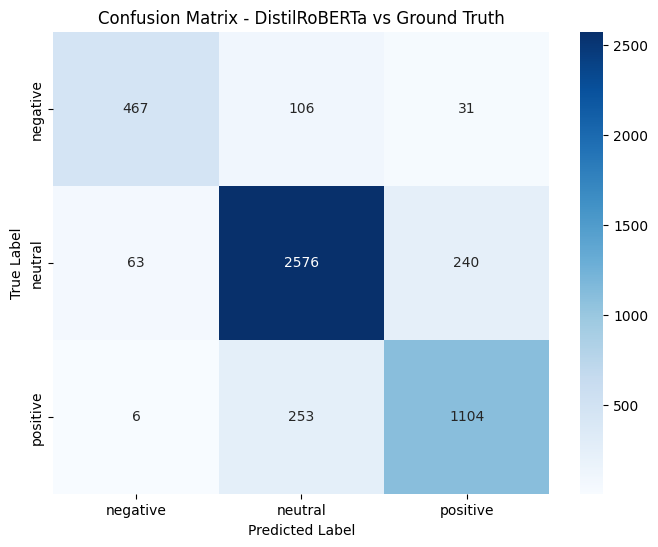

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = df2['sentiment']
y_pred = df2['distilroberta_sentiment']

acc = accuracy_score(y_true, y_pred)
print(f"\n Accuracy: {acc:.4f}")

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix - DistilRoBERTa vs Ground Truth')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Agreement count: 4147
Disagreement count: 699


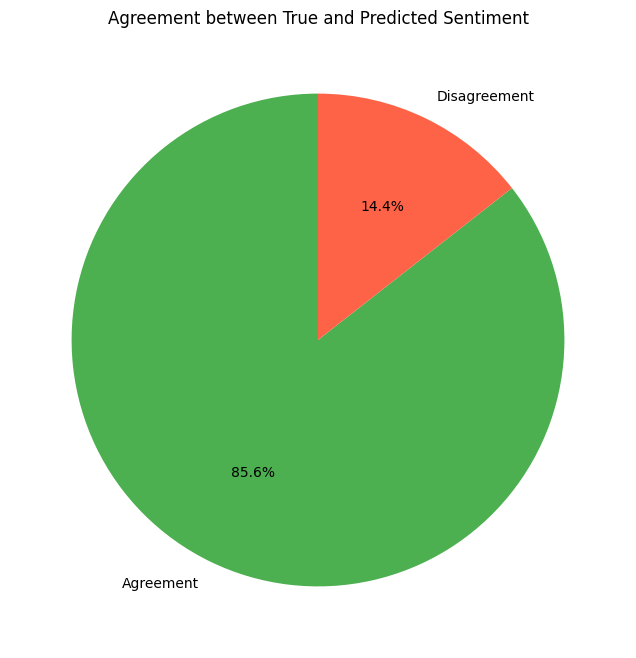

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

agreement = (df2['sentiment'] == df2['distilroberta_sentiment']).sum()
disagreement = len(df2) - agreement

# counts
print(f"Agreement count: {agreement}")
print(f"Disagreement count: {disagreement}")

agreement_counts = pd.DataFrame({'count': [agreement, disagreement]},
                                index=['Agreement', 'Disagreement'])

plt.figure(figsize=(8, 8))
plt.pie(agreement_counts['count'], labels=agreement_counts.index, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FF6347'])
plt.title('Agreement between True and Predicted Sentiment')
plt.show()

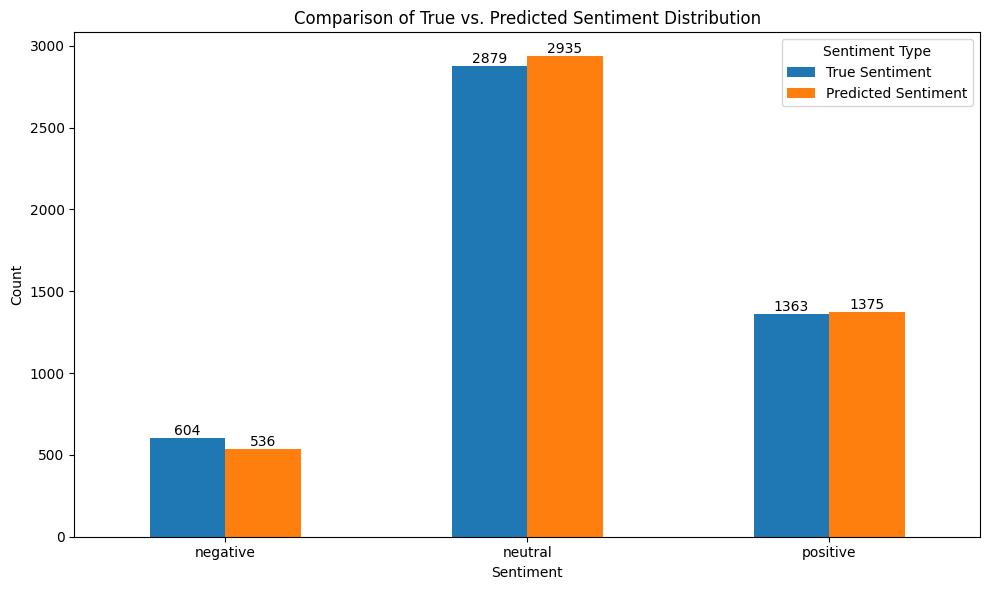

In [18]:
true_sentiment_counts = df2['sentiment'].value_counts().sort_index()
predicted_sentiment_counts = df2['distilroberta_sentiment'].value_counts().sort_index()

sentiment_comparison = pd.DataFrame({
    'True Sentiment': true_sentiment_counts,
    'Predicted Sentiment': predicted_sentiment_counts
})

ax = sentiment_comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of True vs. Predicted Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sentiment Type')
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.show()

In [21]:
# Confidence errors
high_conf_error = df2[(df2['distilroberta_confidence'] >= 0.9) & (df2['true_sentiment'] != df2['distilroberta_sentiment'])]
print(f" {len(high_conf_error)} high confidence errors")

 610 high confidence errors
